# Validation Analysis - Figures

In [24]:
import pandas as pd
import geopandas as gpd
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [59]:
# File was manually copied and pasted. Revisit to automatically generate
wq_sst = pd.read_csv('./data/AllTemps_WaterQualityMURGeopolar_round2.csv')
# wq_sst = pd.read_csv('./data/AllTemps_WaterQualityMURGeopolar_round2_filtered_by_depth7m.csv')
# wq_sst = pd.read_csv('./data/AllTemps_WaterQualityMURGeopolar_round2_filtered_by_depth2m.csv')

In [60]:
# TODO: Move this to previous processing script (ideally never generate the column)
wq_sst = wq_sst.drop('Unnamed: 0', axis=1)

In [61]:
wq_sst

,MeasureValue,Latitude,Longitude,SampleDate,geopolar_sst,mur_sst
0,24.890833,37.24181,-76.38634,2002-09-05,25.269989,25.484009
1,24.628000,37.31181,-76.34634,2002-09-05,25.269989,25.334991
2,24.954545,37.41153,-76.15966,2002-09-05,25.229980,25.084991
3,25.022000,37.48680,-76.15633,2002-09-05,25.199982,24.988983
4,25.058333,37.53069,-76.30661,2002-09-05,25.149994,25.057983
...,...,...,...,...,...,...
41496,8.880000,38.34133,-75.88834,2022-03-16,8.070007,NaN
41497,10.550000,39.27755,-76.44368,2022-03-17,8.289978,NaN
41498,9.200000,39.37747,-76.33465,2022-03-17,8.070007,NaN
41499,9.500000,39.46704,-75.87368,2022-03-17,7.929993,NaN


## Computing $R^2$ and creating scatter plot

### Preprocessing and $R^2$

In [62]:
def mx_plus_b(x):
    return slope * x + intercept

In [63]:
filtered_mur = wq_sst[~wq_sst['mur_sst'].isnull()]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(filtered_mur['MeasureValue'], 
                                                                     filtered_mur['mur_sst'])

print('MUR: slope', slope, 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

MUR: slope 0.9757544728767248 intercept 0.1087340655608493 r squared 0.9393915811875703 p_value 0.0


In [64]:
filtered_geop = wq_sst[~wq_sst['geopolar_sst'].isnull()]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(filtered_geop['MeasureValue'], 
                                                                     filtered_geop['geopolar_sst'])
print('GEOPOLAR: slope', slope, 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

GEOPOLAR: slope 0.9530403711405848 intercept 0.5328813729859689 r squared 0.9466521076512354 p_value 0.0


**TODO** (if using this figure)
- fix overplotting

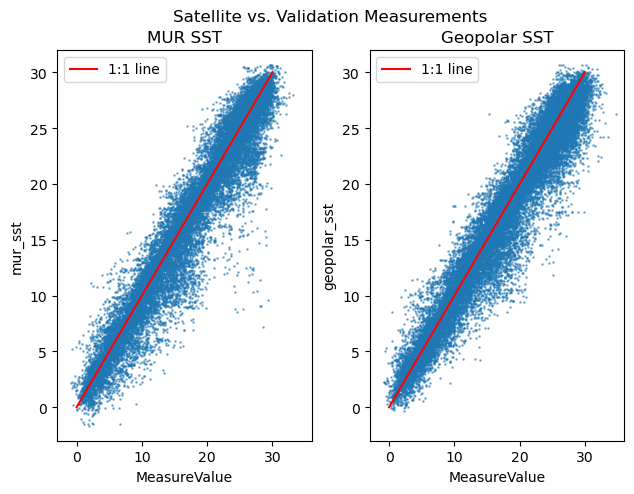

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Satellite vs. Validation Measurements')
fig.tight_layout()

filtered_mur.plot.scatter(ax=ax1, x='MeasureValue', y='mur_sst', alpha=0.5, s=0.8)
ax1.set_title('MUR SST')

filtered_geop.plot.scatter(ax=ax2, x='MeasureValue', y='geopolar_sst', alpha=0.5, s=0.8)
ax2.set_title('Geopolar SST')

for ax in (ax1, ax2):
    ax.plot([0, 30], [0, 30], color='red', label='1:1 line')
    ax.legend(loc="upper left")
    ax.set_xlim([-3, 36])
    ax.set_ylim([-3, 32])

plt.savefig('./figures/validation_analysis/satellite_validation_scatterplot.jpeg')

## Error Maps

### Preprocessing

In [66]:
wq_sst['geopolar_diff'] = wq_sst['geopolar_sst'] - wq_sst['MeasureValue']
wq_sst['mur_diff'] = wq_sst['mur_sst'] - wq_sst['MeasureValue']

In [67]:
temps_mean = wq_sst.groupby(['Latitude', 'Longitude']).mean()
temps_count = wq_sst.groupby(['Latitude', 'Longitude']).count()

temps_mean = temps_mean.reset_index()
temps_count = temps_count.reset_index()

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1985/551031720.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps_mean = wq_sst.groupby(['Latitude', 'Longitude']).mean()


In [68]:
temps_mean_gpd = gpd.GeoDataFrame(
    temps_mean, geometry=gpd.points_from_xy(temps_mean['Longitude'], temps_mean['Latitude']), 
    crs='epsg:4326'
)

temps_count_gpd = gpd.GeoDataFrame(
    temps_count, geometry=gpd.points_from_xy(temps_count['Longitude'], temps_count['Latitude']), 
    crs='epsg:4326'
)

In [69]:
temps_full_gpd = gpd.GeoDataFrame(
    wq_sst, geometry=gpd.points_from_xy(wq_sst['Longitude'], wq_sst['Latitude']), 
    crs='epsg:4326'
)

### Plotting

**TODO**: figure out if there is a way to improve the resolution of the coastline, so it doesn't look like there are datapoints being taken on land.

**TODO**: Awkward spacing

In [70]:
print('Geopolar max/min:', temps_mean_gpd.geopolar_diff.max(), temps_mean_gpd.geopolar_diff.min())
print('MUR max/min:', temps_mean_gpd.mur_diff.max(), temps_mean_gpd.mur_diff.min())

Geopolar max/min: 3.1599890136718756 -4.736256408691407
MUR max/min: 1.5973969726562491 -4.438175455729167


In [58]:
vmin, vmax = -4.75, 4.75

In [42]:
norm = matplotlib.colors.SymLogNorm(linthresh=1, vmin=-5, vmax=5, base=10)

Text(0.5, 1.0, 'Geopolar SST - Validation SST')

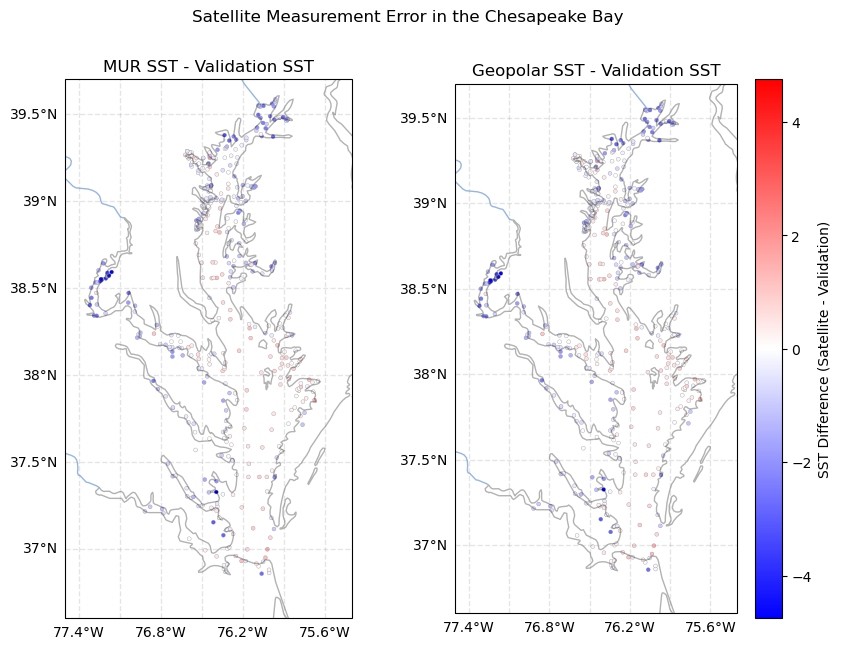

In [43]:
fig, axes = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 7)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Error in the Chesapeake Bay')
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add MUR to left plot
temps_mean_gpd.plot(ax=axes[0], column='mur_diff', markersize=8, cmap='bwr', 
                    legend_kwds={'label': "SST Difference (MUR - Validation)"}, vmin=vmin, 
                    vmax=vmax, edgecolor='grey', linewidth=0.2)
axes[0].set_title('MUR SST - Validation SST')
    
# Add Geopolar to right plot
temps_mean_gpd.plot(ax=axes[1], column='geopolar_diff', markersize=8, cmap='bwr', legend=True, 
                    legend_kwds={'label': "SST Difference (Satellite - Validation)"}, vmin=vmin, 
                    vmax=vmax, edgecolor='grey', linewidth=0.2)
axes[1].set_title('Geopolar SST - Validation SST')

# save
# plt.savefig('./figures/validation_analysis/validation_errors_map.png', dpi=400, bbox_inches='tight')

## Hovm&#246;ller Plot for Seasonality



In [17]:
def create_hovmoller_matrix(temps, satellite):
    temps = temps.set_index(pd.to_datetime(temps['SampleDate']))
    temps = temps.resample('M').mean()
    
    temps = temps[[satellite + '_diff']]
    
    temps['month'] = temps.index.month
    temps['year'] = temps.index.year
    
    matrix = temps.pivot(index='year', columns='month')
    
    print('matrix min / max', satellite, ':', matrix.min().min(), matrix.max().max())
    return matrix

In [18]:
matrix_geop = create_hovmoller_matrix(wq_sst, 'geopolar')
matrix_mur = create_hovmoller_matrix(wq_sst, 'mur')

matrix min / max geopolar : -2.889340907261012 1.9103295778533833
matrix min / max mur : -5.219430117402185 2.724176421653334


/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1985/247615185.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1985/247615185.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()


In [19]:
vmin, vmax = -2.9, 2.9

In [20]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.5, 1.0, 'Geopolar Error by Month and Year')

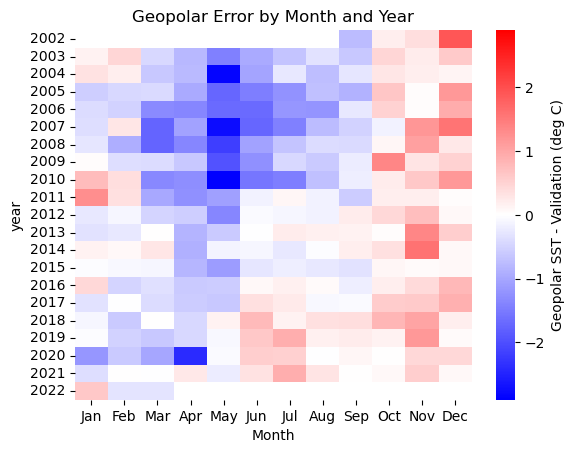

In [23]:
fig, ax = plt.subplots()
sns.heatmap(matrix_geop, cmap='bwr', vmin=vmin, vmax=vmax, 
            cbar_kws={'label': 'Geopolar SST - Validation (deg C)'})

ax.set_xticklabels(months, rotation=0)
ax.set_xlabel('Month')

plt.title('Geopolar Error by Month and Year')

# plt.savefig('../plots/geopolar_hovmoller_error_norivers.png', dpi=350, 
#             bbox_inches='tight')

Text(0.5, 1.0, 'MUR Error by Month and Year')

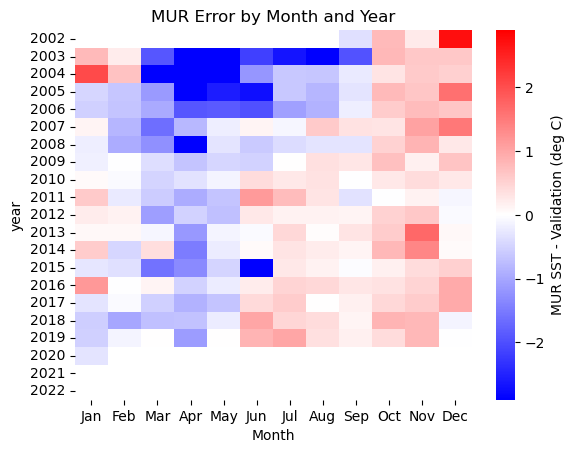

In [22]:
fig, ax = plt.subplots()
sns.heatmap(matrix_mur, cmap='bwr', vmin=vmin, vmax=vmax,
           cbar_kws={'label': 'MUR SST - Validation (deg C)'})

ax.set_xticklabels(months, rotation=0)
ax.set_xlabel('Month')

plt.title('MUR Error by Month and Year')